<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [32]</a>'.</span>

# Quantile-quantile (QQ) scaled climate projections

In [14]:
import geopandas as gp

import logging
import glob
import calendar
import sys
import gc

import xarray as xr
import xclim as xc
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
from clisops.core.subset import subset_shape

#from calc_adjustment import read_data


In [5]:
def read_data(
    infiles,
    var,
    time_bounds=None,
    input_units=None,
    output_units=None,
    lon_chunk_size=None,
):
    """Read and process an input dataset."""

    if len(infiles) == 1:
        ds = xr.open_dataset(infiles[0])
    else:
        ds = xr.open_mfdataset(infiles)

    try:
        ds = ds.drop('height')
    except ValueError:
        pass

    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})

    chunk_dict = {'time': -1}
    if lon_chunk_size:
        chunk_dict['lon'] = lon_chunk_size
    ds = ds.chunk(chunk_dict)
    logging.info(f'Array size: {ds[var].shape}')
    logging.info(f'Chunk size: {ds[var].chunksizes}')

    if input_units:
        ds[var].attrs['units'] = input_units
    if output_units:
        ds[var] = xc.units.convert_units_to(ds[var], output_units)

    return ds

In [6]:
dask.diagnostics.ProgressBar().register()

In [7]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [8]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/pr-qqscale-factors-multiplicative_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/pr-qqscaled-multiplicative_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 6
cmip_units = "kg m-2 s-1"
obs_units = "mm day-1"
qq_units = "mm day-1"
cmip_var = "pr"
obs_var = "precip"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
fut_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/gn/latest/pr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
obs_files = "/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
fut_time_bounds = "2035-01-01 2064-12-31"
obs_time_bounds = "1990-01-01 2019-12-31"

In [9]:
# Required parameters
assert 'cmip_var' in locals(), "Must provide a CMIP variable name (option -p cmip_var {name})"
assert 'obs_var' in locals(), "Must provide a observations variable name (option -p obs_var {name})"
assert 'cmip_units' in locals(), "Must provide CMIP units name (option -p cmip_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'fut_files' in locals(), """Must provide future data files (option -p fut_files {"file paths"})"""
assert 'obs_files' in locals(), """Must provide observational data files (option -p obs_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'obs_time_bounds' in locals(), """Must provide time bounds for observations (option -p obs_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical GCM data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'fut_time_bounds' in locals(), """Must provide time bounds for future GCM data (option -p fut_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [10]:
hist_files = hist_files.split()
fut_files = fut_files.split()
obs_files = obs_files.split()

obs_time_bounds = obs_time_bounds.split()
hist_time_bounds = hist_time_bounds.split()
fut_time_bounds = fut_time_bounds.split()

if cmip_var in ['tasmax']:
    regular_cmap = 'hot_r'
    diverging_cmap = 'RdBu_r'
elif cmip_var in ['tasmin']:
    regular_cmap = cmocean.cm.ice
    diverging_cmap = 'RdBu_r'
elif cmip_var in ['pr']:
    regular_cmap = cmocean.cm.rain
    diverging_cmap = 'BrBG'
else:
    raise ValueError(f'No cmap defined for {cmip_var}')

## Read data

In [15]:
ds_obs = read_data(
    obs_files,
    obs_var,
    time_bounds=obs_time_bounds,
    input_units=obs_units,
    output_units=qq_units
)

/g/data/wp00/users/dbi599/miniconda3/envs/test/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/wp00/users/dbi599/miniconda3/envs/test/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
INFO:root:Array size: (10957, 691, 886)
INFO:root:Chunk size: Frozen({'time': (10957,), 'lat': (691,), 'lon': (886,)})


In [16]:
ds_obs[obs_var]

<xarray.DataArray 'precip' (time: 10957, lat: 691, lon: 886)>
dask.array<xarray-precip, shape=(10957, 691, 886), dtype=float32, chunksize=(10957, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:                 2010-10-23 14:49:46 UTC
    analysis_version_number:       3.01
    cell_methods:                  time: sum
    frequency:                     daily
    length_scale_for_analysis:     80.0
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    source:                        Interpolated surface observations
    standard_name:                 lwe_thickness_of_precipitation_amount
    units:                         mm d-1

In [17]:
lat_min_obs = ds_obs['lat'].values.min()
lat_max_obs = ds_obs['lat'].values.max()
lon_min_obs = ds_obs['lon'].values.min()
lon_max_obs = ds_obs['lon'].values.max()

In [18]:
print(lat_min_obs, lat_max_obs, lon_min_obs, lon_max_obs)

-44.5 -10.0 112.0 156.25


In [19]:
ds_hist = read_data(
    hist_files,
    cmip_var,
    time_bounds=hist_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_hist[cmip_var]

INFO:root:Array size: (7305, 145, 192)
INFO:root:Chunk size: Frozen({'time': (7305,), 'lat': (145,), 'lon': (192,)})


<xarray.DataArray 'pr' (time: 7305, lat: 145, lon: 192)>
dask.array<mul, shape=(7305, 145, 192), dtype=float32, chunksize=(7305, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T17:41:46Z altered by CMOR: replaced missing va...

In [20]:
ds_future = read_data(
    fut_files,
    cmip_var,
    time_bounds=fut_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_future[cmip_var]

INFO:root:Array size: (10958, 145, 192)
INFO:root:Chunk size: Frozen({'time': (10958,), 'lat': (145,), 'lon': (192,)})


<xarray.DataArray 'pr' (time: 10958, lat: 145, lon: 192)>
dask.array<mul, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          mm d-1
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T10:39:53Z altered by CMOR: replaced missing va...

In [21]:
ds_adjust = xr.open_dataset(adjustment_file)
#qm = sdba.QuantileDeltaMapping.from_dataset(ds_adjust)

In [22]:
qq_obs = xr.open_dataset(qq_file)

## Quantile mapping

In [23]:
def quantile_month_plot(da, cmap=None, diverging=False, point=None):
    """Create two dimensional month/quantile plot"""

    fig, ax = plt.subplots(figsize=[16, 6])
    if 'lat' in da.dims:
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    if diverging:
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    quantiles.transpose('month', 'quantiles').plot(cmap=cmap, vmax=vmax, vmin=vmin)
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    plt.yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    plt.show()

In [24]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, cmap=None, diverging=False,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
#    if lat_bounds:
#        lat_min_obs, lat_max_obs = lat_bounds
#        da_selection = da_selection.sel(lat=slice(lat_min_obs, lat_max_obs))
#    if lon_bounds:
#        lon_min_obs, lon_max_obs = lon_bounds
#        da_selection = da_selection.sel(lon=slice(lon_min_obs, lon_max_obs))
    
    shapefile = '/g/data/wp00/shared_code/shapefiles/australia/australia.shp'
    shape = gp.read_file(shapefile)
    da_selection = subset_shape(da_selection, shape=shape)
        
    if diverging:
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        vmax=vmax,
        vmin=vmin,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

INFO:fiona.ogrext:Failed to auto identify EPSG: 7
/jobfs/62939184.gadi-pbs/ipykernel_2324481/3851399869.py:33: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


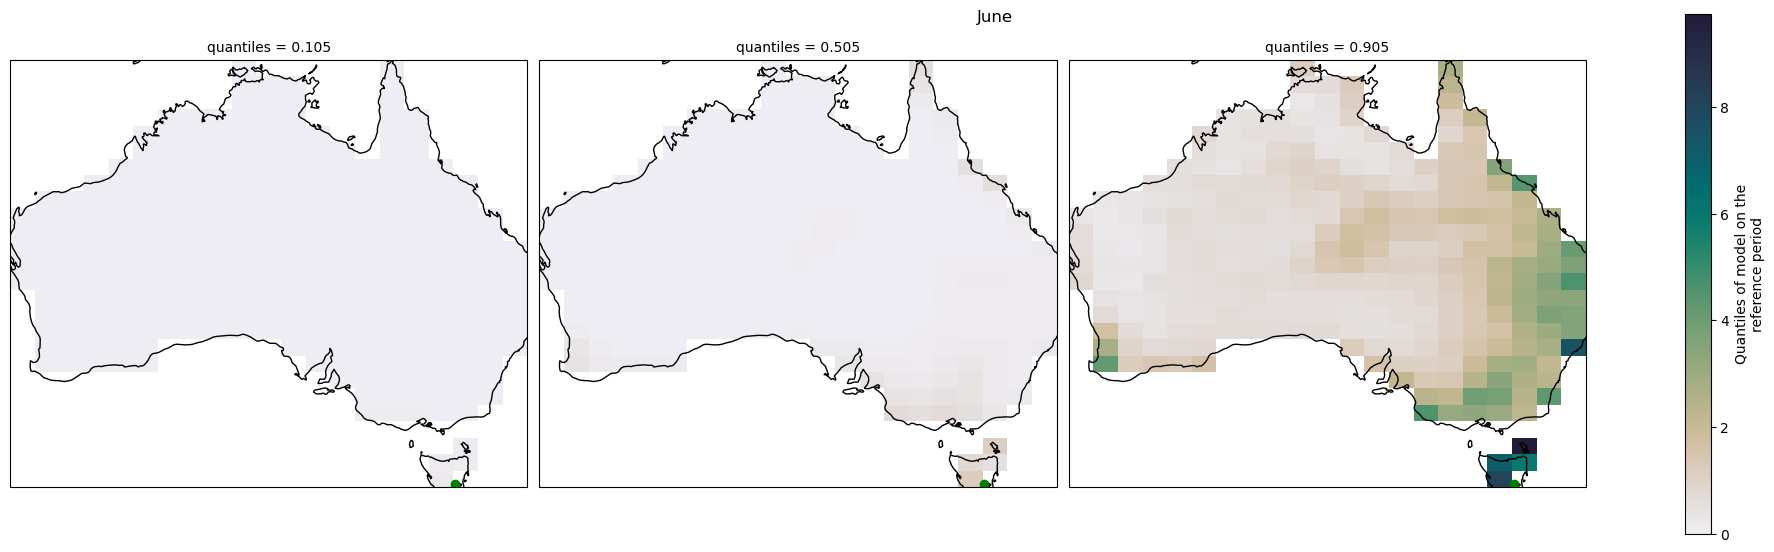

In [25]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        cmap=regular_cmap,
    )

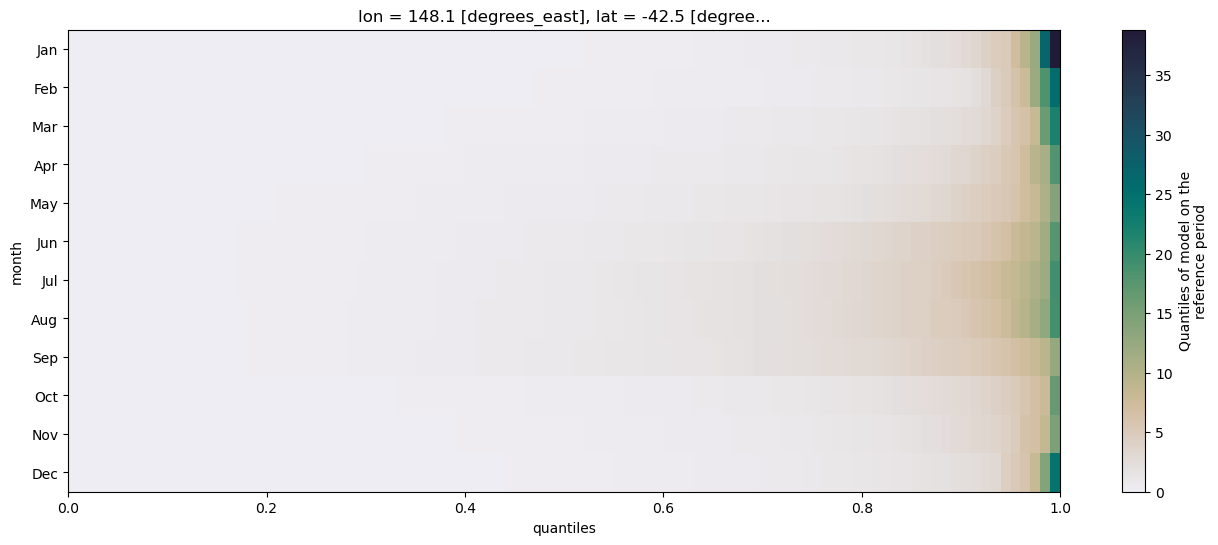

In [27]:
quantile_month_plot(ds_adjust['hist_q'], cmap=regular_cmap)

In [28]:
ds_adjust['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Attributes:
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

In [62]:
ds_adjust['af'].isel({'quantiles': 20, 'month': 5}).values.min()

nan

In [63]:
ds_adjust['af'].isel({'quantiles': 20, 'month': 5}).values.max()

nan

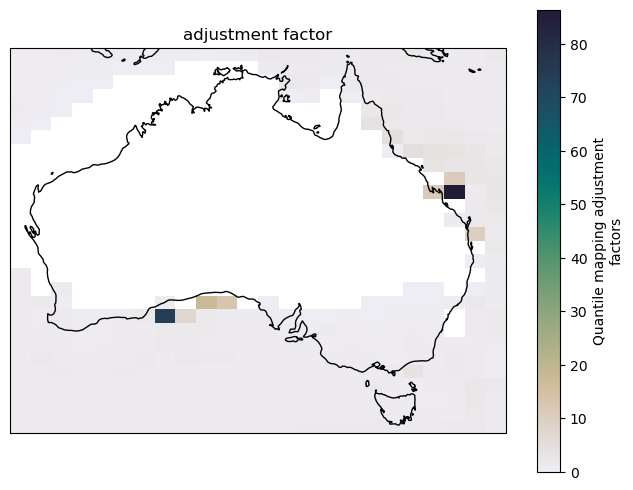

In [60]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_adjust['af'].isel({'quantiles': 10, 'month': 5}).sel(model_sel).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=regular_cmap,
)
ax.set_title('adjustment factor')
ax.coastlines()
plt.show()

INFO:fiona.ogrext:Failed to auto identify EPSG: 7
/jobfs/62939184.gadi-pbs/ipykernel_2324481/3851399869.py:33: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


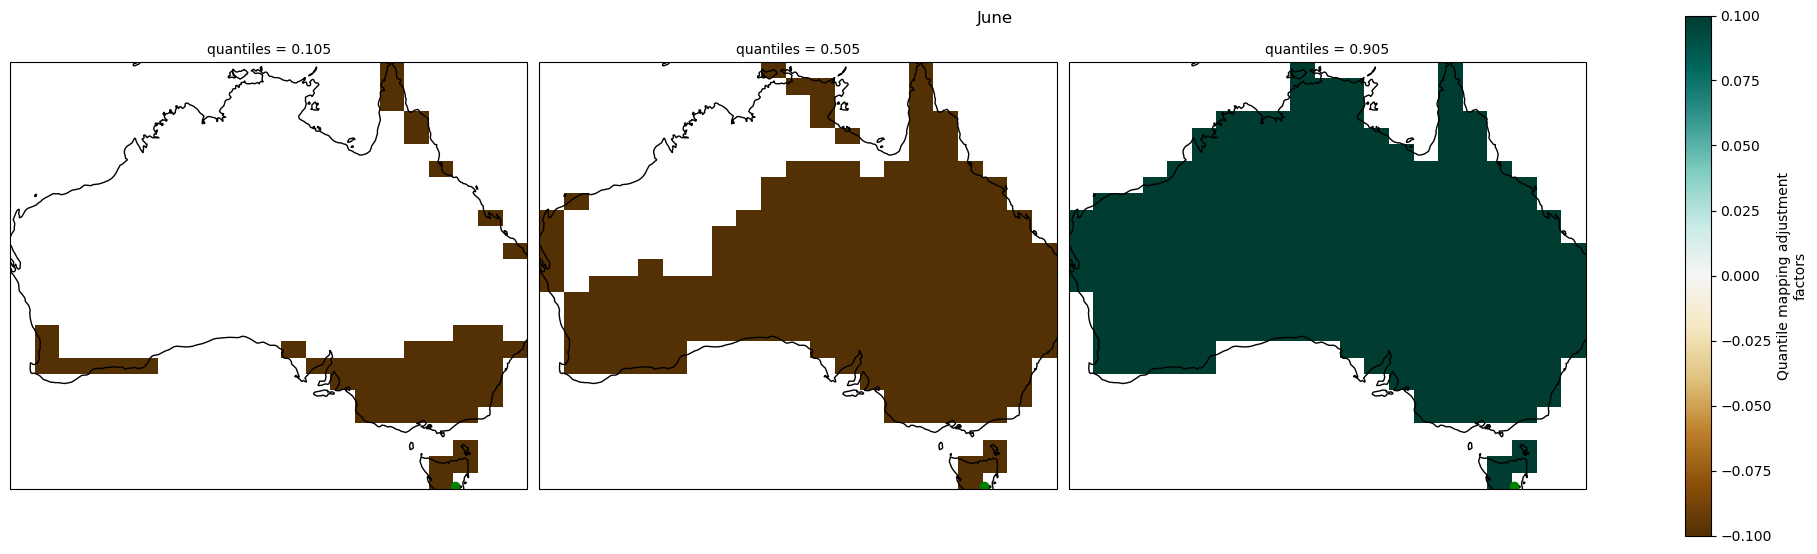

In [29]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        cmap=diverging_cmap,
        diverging=True,
    )

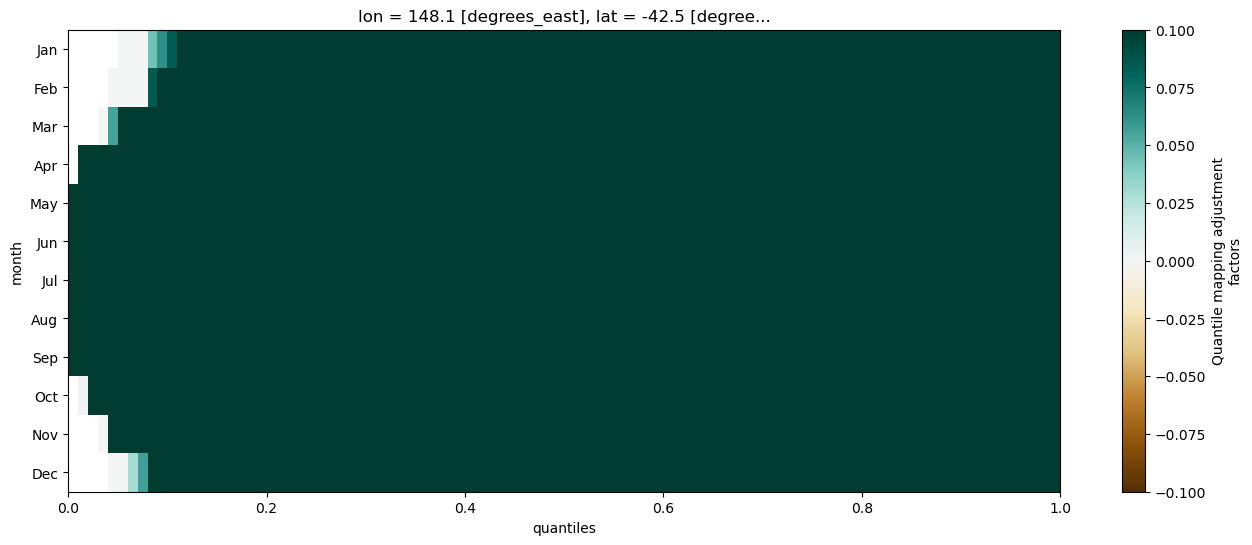

In [30]:
quantile_month_plot(ds_adjust['af'], cmap=diverging_cmap, diverging=True)

## QQ-scaled projections

In [31]:
model_sel = {'lat': slice(lat_min_obs, lat_max_obs), 'lon': slice(lon_min_obs, lon_max_obs)}

In [32]:
hist_clim = ds_hist[cmip_var].mean('time', keep_attrs=True)
future_clim = ds_future[cmip_var].mean('time', keep_attrs=True)
model_mean_change = future_clim - hist_clim

[########################################] | 100% Completed | 6.58 ss
[########################################] | 100% Completed | 9.46 ss


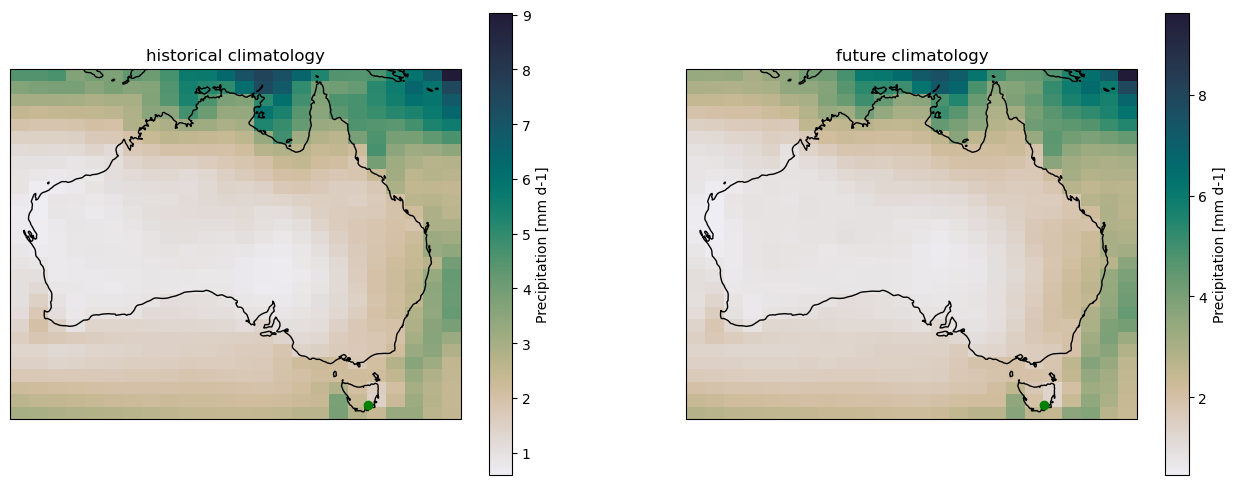

In [39]:
fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
hist_clim.sel(model_sel).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=regular_cmap,
)
ax1.set_title('historical climatology')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
future_clim.sel(model_sel).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=regular_cmap,
)
ax2.set_title('future climatology')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

#plt.suptitle('Projected change')
plt.show()

In [33]:
model_mean_change = model_mean_change.compute()

[########################################] | 100% Completed | 30.42 s


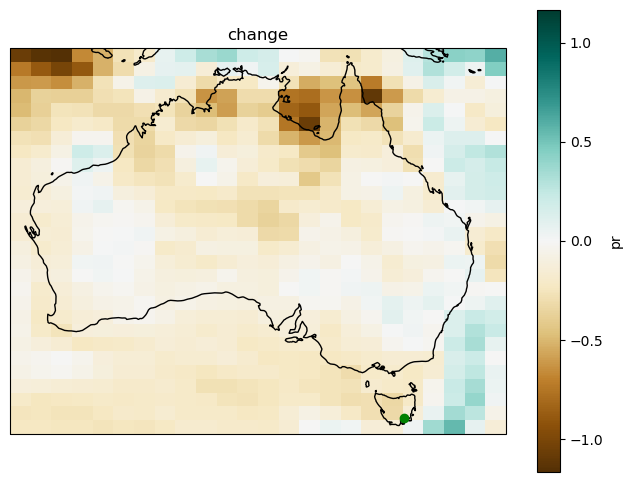

In [42]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
model_mean_change.sel(model_sel).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
)
ax.set_title('change')
ax.coastlines()
ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
plt.show()

In [43]:
obs_clim = ds_obs[obs_var].mean('time', keep_attrs=True)
qq_clim = qq_obs[obs_var].mean('time', keep_attrs=True)
qq_mean_change = qq_clim - obs_clim

/g/data/wp00/users/dbi599/miniconda3/envs/test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[########################################] | 100% Completed | 413.85 s


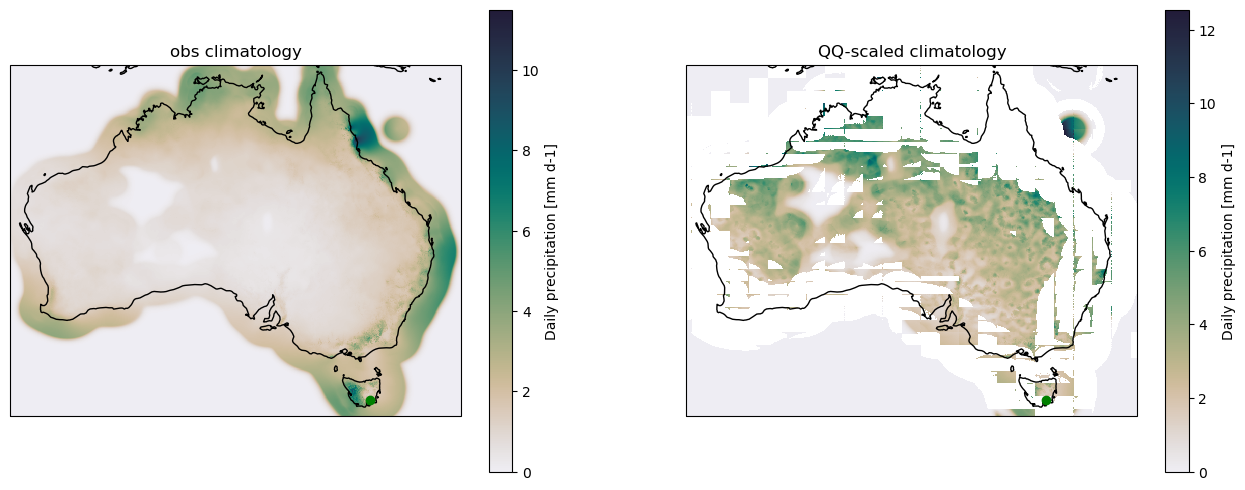

In [44]:
fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
obs_clim.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=regular_cmap,
)
ax1.set_title('obs climatology')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qq_clim.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=regular_cmap,
)
ax2.set_title('QQ-scaled climatology')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

#plt.suptitle('Projected change')
plt.show()

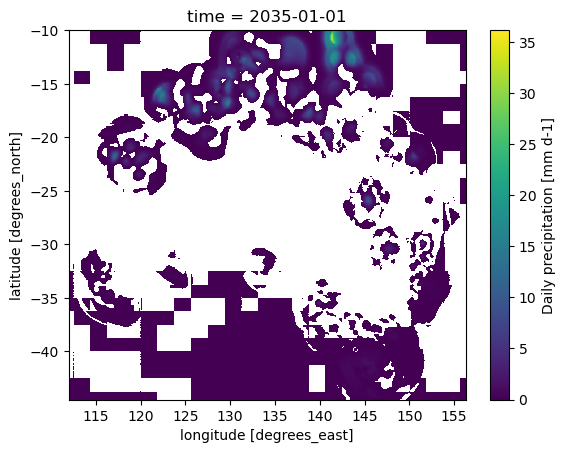

In [48]:
qq_obs[obs_var].isel({'time': 0}).plot()

In [26]:
qq_mean_change = qq_mean_change.compute()

[########################################] | 100% Completed | 383.37 s


In [27]:
regridder = xe.Regridder(model_mean_change, qq_mean_change, "bilinear")
model_mean_change_regridded = regridder(model_mean_change)

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [28]:
mean_change_difference = qq_mean_change - model_mean_change_regridded

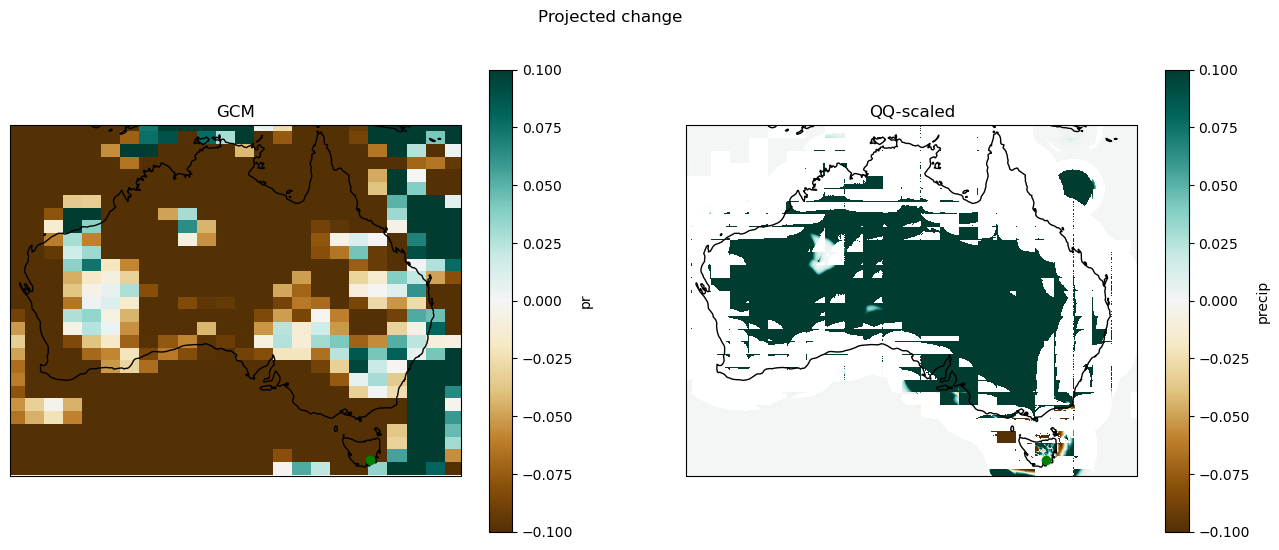

In [29]:
model_abs_max = np.max(np.abs(model_mean_change.sel(model_sel).values))
qq_abs_max = np.max(np.abs(qq_mean_change.values))
abs_max = np.max([model_abs_max, qq_abs_max])
vmax = abs_max
vmin = -1 * abs_max

fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
model_mean_change.sel(model_sel).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    vmax=vmax,
    vmin=vmin
)
ax1.set_title('GCM')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    vmax=vmax,
    vmin=vmin
)
ax2.set_title('QQ-scaled')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.suptitle('Projected change')
plt.show()

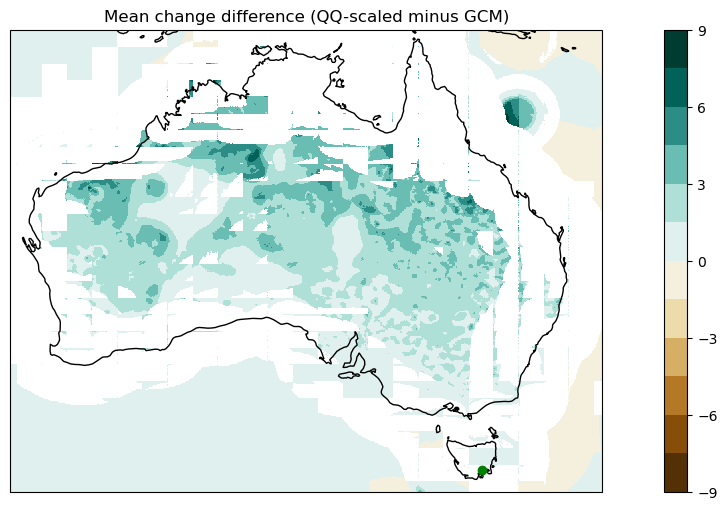

In [30]:
fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
mean_change_difference.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=diverging_cmap,
    levels=13,
)
ax1.set_title('Mean change difference (QQ-scaled minus GCM)')

ax1.coastlines()
ax1.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())

#plt.suptitle(f'{model_name}, {future_scenario} projected change')
plt.show()

[########################################] | 100% Completed | 7.02 ss
[########################################] | 100% Completed | 8.63 ss
[########################################] | 100% Completed | 625.37 ms


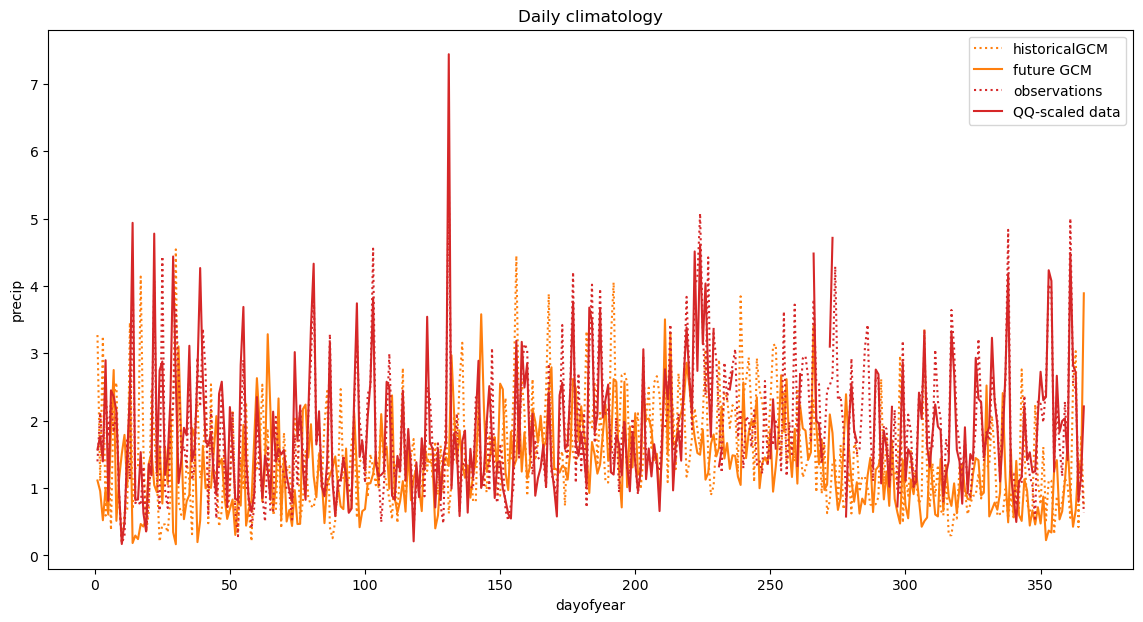

In [31]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in qq_obs.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historicalGCM", color='tab:orange', linestyle=':')
ds_future[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="future GCM", color='tab:orange')
ds_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="observations", color='tab:red', linestyle=':')
qq_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled data", color='tab:red')
plt.legend()
plt.title('Daily climatology')
plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

[########################################] | 100% Completed | 102.29 ms


ValueError: supplied range of [0.0, inf] is not finite

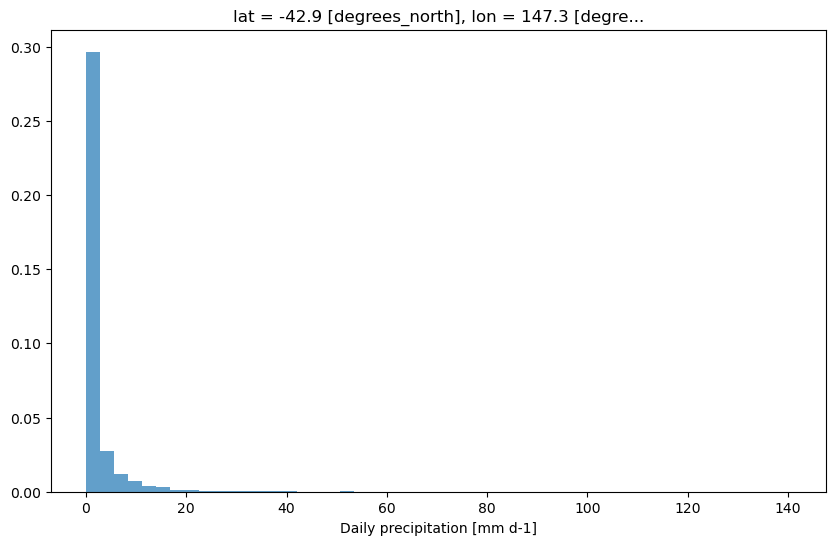

In [32]:
fig = plt.figure(figsize=[10, 6])
if 'lat' in qq_obs.dims:
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='observations', alpha=0.7)
qq_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='QQ-scaled data', facecolor='green', alpha=0.7)
plt.ylabel('probability')
plt.legend()
plt.show()